In [1]:
import os, math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
# ---------- Small helper block ----------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


# ---------- Encoder: 4-level downsampling ----------
class Encoder4L(nn.Module):
    """
    Input:  (B, 1, 125, 125)
    Output: bottleneck z: (B, 256, 7, 7)
    Also returns skip features for U-Net-style decoding.
    """
    def __init__(self, in_channels=1, base_channels=32):
        super().__init__()
        c1 = base_channels          # 32
        c2 = base_channels * 2      # 64
        c3 = base_channels * 4      # 128
        c4 = base_channels * 8      # 256

        # Downsample convs: stride=2, kernel=4, pad=1  -> 125→62→31→15→7
        self.down1 = nn.Conv2d(in_channels, c1, kernel_size=4, stride=2, padding=1)  # 125→62
        self.down2 = nn.Conv2d(c1, c2, kernel_size=4, stride=2, padding=1)           # 62→31
        self.down3 = nn.Conv2d(c2, c3, kernel_size=4, stride=2, padding=1)           # 31→15
        self.down4 = nn.Conv2d(c3, c4, kernel_size=4, stride=2, padding=1)           # 15→7

        self.conv1 = ConvBlock(c1, c1)
        self.conv2 = ConvBlock(c2, c2)
        self.conv3 = ConvBlock(c3, c3)
        self.conv4 = ConvBlock(c4, c4)

    def forward(self, x):
        # x: (B,1,125,125)
        x1 = self.down1(x)   # (B,32,62,62)
        x1 = self.conv1(x1)

        x2 = self.down2(x1)  # (B,64,31,31)
        x2 = self.conv2(x2)

        x3 = self.down3(x2)  # (B,128,15,15)
        x3 = self.conv3(x3)

        x4 = self.down4(x3)  # (B,256,7,7)
        x4 = self.conv4(x4)  # bottleneck

        # return bottleneck + skips
        return x4, (x3, x2, x1)


# ---------- Decoder: upsample with skips ----------
class Decoder4L(nn.Module):
    """
    Input:  bottleneck z: (B, 256, 7, 7)
    Output: logits: (B, 1, 125, 125)
    Uses skip connections from encoder.
    """
    def __init__(self, out_channels=1, base_channels=32):
        super().__init__()
        c1 = base_channels          # 32
        c2 = base_channels * 2      # 64
        c3 = base_channels * 4      # 128
        c4 = base_channels * 8      # 256

        # Transposed convs chosen so:
        # 7→15 (op=1), 15→31 (op=1), 31→62 (op=0), 62→125 (op=1)
        self.up1 = nn.ConvTranspose2d(c4, c3, kernel_size=4, stride=2, padding=1, output_padding=1)  # 7→15
        self.up2 = nn.ConvTranspose2d(c3, c2, kernel_size=4, stride=2, padding=1, output_padding=1)  # 15→31
        self.up3 = nn.ConvTranspose2d(c2, c1, kernel_size=4, stride=2, padding=1, output_padding=0)  # 31→62
        self.up4 = nn.ConvTranspose2d(c1, c1, kernel_size=4, stride=2, padding=1, output_padding=1)  # 62→125

        # after concat with skip, double the channels
        self.dec3 = ConvBlock(c3 + c3, c3)
        self.dec2 = ConvBlock(c2 + c2, c2)
        self.dec1 = ConvBlock(c1 + c1, c1)

        # final 1×1 conv to produce logits
        self.out_conv = nn.Conv2d(c1, out_channels, kernel_size=1)

    def forward(self, z, skips):
        x3, x2, x1 = skips  # shapes: (B,128,15,15), (B,64,31,31), (B,32,62,62)

        d3 = self.up1(z)                 # (B,128,15,15)
        d3 = torch.cat([d3, x3], dim=1)  # (B,256,15,15)
        d3 = self.dec3(d3)               # (B,128,15,15)

        d2 = self.up2(d3)                # (B,64,31,31)
        d2 = torch.cat([d2, x2], dim=1)  # (B,128,31,31)
        d2 = self.dec2(d2)               # (B,64,31,31)

        d1 = self.up3(d2)                # (B,32,62,62)
        d1 = torch.cat([d1, x1], dim=1)  # (B,64,62,62)
        d1 = self.dec1(d1)               # (B,32,62,62)

        out = self.up4(d1)               # (B,32,125,125)
        logits = self.out_conv(out)      # (B,1,125,125)
        return logits

class AE(nn.Module):
    """
    4-level downsampling autoencoder for arc segmentation.
    Forward:
        logits, loss (if target provided)
    """
    def __init__(self, base_channels=32, pos_weight=4.0):
        super().__init__()
        self.encoder = Encoder4L(in_channels=1, base_channels=base_channels)
        self.decoder = Decoder4L(out_channels=1, base_channels=base_channels)
        self.register_buffer("pos_weight", torch.tensor([pos_weight], dtype=torch.float32))

    def forward(self, noisy_input, arc_target=None):
        # noisy_input: (B,1,125,125)
        z, skips = self.encoder(noisy_input)
        logits = self.decoder(z, skips)

        if arc_target is not None:
            loss = F.binary_cross_entropy_with_logits(
                logits,
                arc_target,
                pos_weight=self.pos_weight
            )
            return logits, loss

        return logits


class LensRadiusNet(nn.Module):
    def __init__(self, encoder, hidden=256):
        super().__init__()
        self.encoder = encoder  # Encoder4L

        z_dim = 256 * 7 * 7
        self.shared = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, hidden),
            nn.ReLU(inplace=True),
        )
        self.cls_head = nn.Linear(hidden, 1)  # lens logit
        self.rad_head = nn.Linear(hidden, 1)  # radius (scalar)

    def forward(self, x):
        z, _ = self.encoder(x)          # (B,256,7,7)
        z = z.flatten(1)                # (B, 256*7*7 = 12544)
        h = self.shared(z)
        lens_logit = self.cls_head(h).squeeze(1)
        radius     = F.softplus(self.rad_head(h)).squeeze(1)
        return lens_logit, radius

In [3]:
import numpy as np

path = "/global/cfs/projectdirs/deepsrch/jwst_sims/pristine_bright/"

x0 = np.load(os.path.join(path, "images.npy"))      # expected (N,H,W) or (N,1,H,W)
y_lens = np.load(os.path.join(path, "lensed.npy"))  # (N,) 0/1
theta_e = np.load(os.path.join(path, "theta_Es.npy"))  # (N,) float

print("raw x0:", x0.shape, x0.dtype)
print("raw y_lens:", y_lens.shape, y_lens.dtype, "unique:", np.unique(y_lens)[:10])
print("raw theta_e:", theta_e.shape, theta_e.dtype)

# --- ensure x0 is (N,1,H,W) float32 ---
x0 = x0.astype(np.float32)

if x0.ndim == 3:
    # (N,H,W) -> (N,1,H,W)
    x0 = x0[:, None, :, :]
elif x0.ndim == 4:
    # if channels-last, convert to channels-first
    if x0.shape[-1] == 1:
        x0 = np.transpose(x0, (0, 3, 1, 2))
    # else assume already (N,1,H,W)
else:
    raise ValueError(f"Unexpected x0 shape: {x0.shape}")

# --- normalize globally (you can also do per-image if you want) ---
mean = x0.mean()
std  = x0.std() + 1e-8
x0 = (x0 - mean) / std

# --- ensure labels are right types ---
y_lens = y_lens.astype(np.int64)      # 0/1
theta_e = theta_e.astype(np.float32)  # float

print("processed x0:", x0.shape, x0.dtype, "mean/std:", x0.mean(), x0.std())

raw x0: (20000, 125, 125) float64
raw y_lens: (20000,) float64 unique: [0. 1.]
raw theta_e: (20000,) float64
processed x0: (20000, 1, 125, 125) float32 mean/std: -2.2253926e-07 1.0000141


In [4]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Make sure labels are proper dtypes
y_lens_i = y_lens.astype(np.int64)
theta_e_f = theta_e.astype(np.float32)

class LensRadiusDataset(Dataset):
    def __init__(self, x, y, r):
        self.x = torch.from_numpy(x)          # (N,1,125,125) float32
        self.y = torch.from_numpy(y)          # (N,) int64 (0/1)
        self.r = torch.from_numpy(r)          # (N,) float32

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.r[idx]

idx = np.arange(len(y_lens_i))
train_idx, val_idx = train_test_split(
    idx,
    test_size=0.2,
    stratify=y_lens_i,
    random_state=42
)

r_mean = theta_e_f[train_idx].mean()
r_std  = theta_e_f[train_idx].std() + 1e-8
theta_e_norm = (theta_e_f - r_mean) / r_std

train_ds = LensRadiusDataset(x0[train_idx], y_lens_i[train_idx], theta_e_norm[train_idx])
val_ds   = LensRadiusDataset(x0[val_idx],   y_lens_i[val_idx],   theta_e_norm[val_idx])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

print("train:", len(train_ds), "val:", len(val_ds))
print("train lens fraction:", (y_lens_i[train_idx].mean()))
print("val lens fraction:",   (y_lens_i[val_idx].mean()))

train: 16000 val: 4000
train lens fraction: 0.5
val lens fraction: 0.5


In [5]:
import torch
import torch.nn as nn
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Build model ---
ae = AE(base_channels=32, pos_weight=4.0)          # AE pos_weight is only used if you train AE with arc_target
model = LensRadiusNet(ae.encoder, hidden=256)       # multitask net uses encoder only

# --- DataParallel (only if multiple GPUs available) ---
if torch.cuda.device_count() > 1:
    print("Using DataParallel with", torch.cuda.device_count(), "GPUs")
    model = torch.nn.DataParallel(model)

model = model.to(device)

# --- Class imbalance for lens classification loss ---
# y_lens should be 0/1 ints
counts = Counter(y_lens[train_idx].tolist())
n_neg = counts.get(0, 0)
n_pos = counts.get(1, 0)
pos_weight_cls = torch.tensor([n_neg / max(n_pos, 1)], dtype=torch.float32).to(device)

bce = nn.BCEWithLogitsLoss()
reg = nn.SmoothL1Loss()
lambda_reg = 1.0

# --- AdaBelief optimizer ---
from adabelief_pytorch import AdaBelief

optimizer = AdaBelief(
    model.parameters(),
    lr=3e-4,
    eps=1e-8,
    betas=(0.9, 0.999),
    weight_decay=1e-5,
    rectify=True,
    print_change_log=False
)

Using DataParallel with 4 GPUs
Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


In [6]:
!nvidia-smi

Sun Dec 21 11:02:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:03:00.0 Off |                    0 |
| N/A   32C    P0             70W /  400W |    3293MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [7]:
from sklearn.metrics import (
    recall_score, roc_auc_score, mean_absolute_error,
    roc_curve, accuracy_score, precision_score
)
import numpy as np
from tqdm import tqdm
import torch

train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_precisions, val_recalls, val_aucs = [], [], []
val_maes = []  # radius MAE on true lenses only

epochs = 500
patience = 40
best_model_path = "models/custom_ae_multi_head.pth"

patience_counter = 0
best_val_auc = -1.0

def unwrap_model(m):
    return m.module if isinstance(m, torch.nn.DataParallel) else m

for epoch in range(epochs):
    # -------------------
    # Train
    # -------------------
    model.train()
    running_loss = 0.0
    correct = 0
    n_total = 0

    # warmup regression
    lambda_reg = 0.0 if epoch < 5 else 0.25

    for x, y, r in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training"):
        x = x.to(device)           # (B,1,125,125)
        y = y.to(device).float()   # (B,)
        r = r.to(device).float()   # (B,)

        optimizer.zero_grad()

        lens_logit, r_pred = model(x)  # (B,), (B,)

        bce_loss = bce(lens_logit, y)

        mask = (y == 1)
        if mask.any():
            reg_loss = reg(r_pred[mask], r[mask])
        else:
            reg_loss = torch.tensor(0.0, device=device)

        loss = bce_loss + lambda_reg * reg_loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # train metrics (threshold 0.5 is fine just to see progress)
        probs = torch.sigmoid(lens_logit)
        preds = (probs >= 0.5).long()
        correct += (preds == y.long()).sum().item()
        n_total += y.numel()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / max(n_total, 1)

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # -------------------
    # Validate
    # -------------------
    model.eval()
    running_loss = 0.0

    all_probs, all_labels = [], []
    all_r_true, all_r_pred = [], []

    with torch.no_grad():
        for x, y, r in tqdm(val_loader, desc=f"[Epoch {epoch+1}] Validation", leave=False):
            x = x.to(device)
            y = y.to(device).float()
            r = r.to(device).float()

            lens_logit, r_pred = model(x)

            bce_loss = bce(lens_logit, y)

            mask = (y == 1)
            if mask.any():
                reg_loss = reg(r_pred[mask], r[mask])
            else:
                reg_loss = torch.tensor(0.0, device=device)

            loss = bce_loss + lambda_reg * reg_loss
            running_loss += loss.item()

            probs = torch.sigmoid(lens_logit)  # (B,)
            all_probs.extend(probs.detach().cpu().numpy())
            all_labels.extend(y.detach().cpu().numpy().astype(int))

            if mask.any():
                all_r_true.extend(r[mask].detach().cpu().numpy())
                all_r_pred.extend(r_pred[mask].detach().cpu().numpy())

    val_loss = running_loss / len(val_loader)
    probs_np = np.array(all_probs)
    labels_np = np.array(all_labels)

    # --- pick best threshold via Youden J ---
    fpr, tpr, thr = roc_curve(labels_np, probs_np)
    best_t = thr[np.argmax(tpr - fpr)]
    preds_np = (probs_np >= best_t).astype(int)

    val_acc = accuracy_score(labels_np, preds_np)
    val_rec = recall_score(labels_np, preds_np, pos_label=1)
    val_prec = precision_score(labels_np, preds_np, pos_label=1, zero_division=0)

    try:
        val_auc = roc_auc_score(labels_np, probs_np)
    except ValueError:
        val_auc = float("nan")

    pred_pos_rate = float((preds_np == 1).mean())
    true_pos_rate = float((labels_np == 1).mean())

    # --- radius MAE (only y=1), convert back to physical units ---
    if len(all_r_true) > 0:
        r_pred_phys = (np.array(all_r_pred) * r_std) + r_mean
        r_true_phys = (np.array(all_r_true) * r_std) + r_mean
        val_mae = mean_absolute_error(r_true_phys, r_pred_phys)
    else:
        val_mae = float("nan")

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_precisions.append(val_prec)
    val_recalls.append(val_rec)
    val_aucs.append(val_auc)
    val_maes.append(val_mae)

    print(
        f"[Epoch {epoch+1}] "
        f"Train Loss: {train_loss:.4f}, Acc@0.5: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Acc@t*: {val_acc:.4f}, "
        f"Prec(Lens): {val_prec:.4f}, Recall(Lens): {val_rec:.4f}, "
        f"AUC: {val_auc:.4f}, Radius MAE(y=1): {val_mae:.4f}"
    )
    print(f"Best threshold t*: {best_t:.4f} | Pred lens rate: {pred_pos_rate:.3f} | True lens rate: {true_pos_rate:.3f}")

    # -------------------
    # Early stopping on AUC
    # -------------------
    improved = np.isfinite(val_auc) and (val_auc > best_val_auc + 1e-4)

    if improved:
        best_val_auc = val_auc
        patience_counter = 0
        torch.save(unwrap_model(model).state_dict(), best_model_path)
        print(f"Saved new best model (AUC={val_auc:.4f}) -> {best_model_path}")
    else:
        patience_counter += 1
        print(f"No AUC improvement. Patience: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

[Epoch 1] Training: 100%|██████████| 125/125 [00:04<00:00, 26.52it/s]
                                                                     

[Epoch 1] Train Loss: 0.6932, Acc@0.5: 0.5000 | Val Loss: 0.6932, Acc@t*: 0.7520, Prec(Lens): 0.7195, Recall(Lens): 0.8260, AUC: 0.8088, Radius MAE(y=1): 0.2528
Best threshold t*: 0.5021 | Pred lens rate: 0.574 | True lens rate: 0.500
Saved new best model (AUC=0.8088) -> models/custom_ae_multi_head.pth


[Epoch 2] Training: 100%|██████████| 125/125 [00:02<00:00, 43.66it/s]
                                                                     

[Epoch 2] Train Loss: 0.6932, Acc@0.5: 0.5000 | Val Loss: 0.6932, Acc@t*: 0.7445, Prec(Lens): 0.7287, Recall(Lens): 0.7790, AUC: 0.8092, Radius MAE(y=1): 0.2528
Best threshold t*: 0.5015 | Pred lens rate: 0.534 | True lens rate: 0.500
Saved new best model (AUC=0.8092) -> models/custom_ae_multi_head.pth


[Epoch 3] Training: 100%|██████████| 125/125 [00:02<00:00, 44.65it/s]
                                                                     

[Epoch 3] Train Loss: 0.6932, Acc@0.5: 0.5000 | Val Loss: 0.6932, Acc@t*: 0.7535, Prec(Lens): 0.7290, Recall(Lens): 0.8070, AUC: 0.8179, Radius MAE(y=1): 0.2528
Best threshold t*: 0.5010 | Pred lens rate: 0.553 | True lens rate: 0.500
Saved new best model (AUC=0.8179) -> models/custom_ae_multi_head.pth


[Epoch 4] Training: 100%|██████████| 125/125 [00:02<00:00, 45.59it/s]
                                                                     

[Epoch 4] Train Loss: 0.6932, Acc@0.5: 0.4968 | Val Loss: 0.6931, Acc@t*: 0.7428, Prec(Lens): 0.7261, Recall(Lens): 0.7795, AUC: 0.8137, Radius MAE(y=1): 0.2527
Best threshold t*: 0.5003 | Pred lens rate: 0.537 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 5] Training: 100%|██████████| 125/125 [00:02<00:00, 44.71it/s]
                                                                     

[Epoch 5] Train Loss: 0.6932, Acc@0.5: 0.4974 | Val Loss: 0.6931, Acc@t*: 0.7440, Prec(Lens): 0.7113, Recall(Lens): 0.8215, AUC: 0.8143, Radius MAE(y=1): 0.2528
Best threshold t*: 0.5008 | Pred lens rate: 0.578 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 6] Training: 100%|██████████| 125/125 [00:02<00:00, 45.50it/s]
                                                                     

[Epoch 6] Train Loss: 0.7327, Acc@0.5: 0.4978 | Val Loss: 0.7312, Acc@t*: 0.7415, Prec(Lens): 0.6937, Recall(Lens): 0.8650, AUC: 0.8082, Radius MAE(y=1): 0.2434
Best threshold t*: 0.5001 | Pred lens rate: 0.624 | True lens rate: 0.500
No AUC improvement. Patience: 3/40


[Epoch 7] Training: 100%|██████████| 125/125 [00:02<00:00, 43.54it/s]
                                                                     

[Epoch 7] Train Loss: 0.7295, Acc@0.5: 0.4931 | Val Loss: 0.7290, Acc@t*: 0.7408, Prec(Lens): 0.7036, Recall(Lens): 0.8320, AUC: 0.8074, Radius MAE(y=1): 0.2385
Best threshold t*: 0.5000 | Pred lens rate: 0.591 | True lens rate: 0.500
No AUC improvement. Patience: 4/40


[Epoch 8] Training: 100%|██████████| 125/125 [00:02<00:00, 43.60it/s]
                                                                     

[Epoch 8] Train Loss: 0.7281, Acc@0.5: 0.4964 | Val Loss: 0.7282, Acc@t*: 0.7428, Prec(Lens): 0.6915, Recall(Lens): 0.8765, AUC: 0.8110, Radius MAE(y=1): 0.2366
Best threshold t*: 0.5001 | Pred lens rate: 0.634 | True lens rate: 0.500
No AUC improvement. Patience: 5/40


[Epoch 9] Training: 100%|██████████| 125/125 [00:02<00:00, 44.10it/s]
                                                                     

[Epoch 9] Train Loss: 0.7276, Acc@0.5: 0.4994 | Val Loss: 0.7279, Acc@t*: 0.7492, Prec(Lens): 0.7288, Recall(Lens): 0.7940, AUC: 0.8169, Radius MAE(y=1): 0.2361
Best threshold t*: 0.5001 | Pred lens rate: 0.545 | True lens rate: 0.500
No AUC improvement. Patience: 6/40


[Epoch 10] Training: 100%|██████████| 125/125 [00:02<00:00, 45.38it/s]
                                                                      

[Epoch 10] Train Loss: 0.7274, Acc@0.5: 0.4978 | Val Loss: 0.7278, Acc@t*: 0.7440, Prec(Lens): 0.7194, Recall(Lens): 0.8000, AUC: 0.8108, Radius MAE(y=1): 0.2360
Best threshold t*: 0.4994 | Pred lens rate: 0.556 | True lens rate: 0.500
No AUC improvement. Patience: 7/40


[Epoch 11] Training: 100%|██████████| 125/125 [00:02<00:00, 44.05it/s]
                                                                      

[Epoch 11] Train Loss: 0.7274, Acc@0.5: 0.4976 | Val Loss: 0.7278, Acc@t*: 0.7432, Prec(Lens): 0.6916, Recall(Lens): 0.8780, AUC: 0.8155, Radius MAE(y=1): 0.2360
Best threshold t*: 0.5002 | Pred lens rate: 0.635 | True lens rate: 0.500
No AUC improvement. Patience: 8/40


[Epoch 12] Training: 100%|██████████| 125/125 [00:02<00:00, 45.77it/s]
                                                                      

[Epoch 12] Train Loss: 0.7273, Acc@0.5: 0.5023 | Val Loss: 0.7278, Acc@t*: 0.7392, Prec(Lens): 0.6976, Recall(Lens): 0.8445, AUC: 0.8096, Radius MAE(y=1): 0.2360
Best threshold t*: 0.5011 | Pred lens rate: 0.605 | True lens rate: 0.500
No AUC improvement. Patience: 9/40


[Epoch 13] Training: 100%|██████████| 125/125 [00:02<00:00, 44.21it/s]
                                                                      

[Epoch 13] Train Loss: 0.7273, Acc@0.5: 0.5007 | Val Loss: 0.7278, Acc@t*: 0.7420, Prec(Lens): 0.6889, Recall(Lens): 0.8825, AUC: 0.8098, Radius MAE(y=1): 0.2361
Best threshold t*: 0.5004 | Pred lens rate: 0.640 | True lens rate: 0.500
No AUC improvement. Patience: 10/40


[Epoch 14] Training: 100%|██████████| 125/125 [00:02<00:00, 42.12it/s]
                                                                      

[Epoch 14] Train Loss: 0.7274, Acc@0.5: 0.4978 | Val Loss: 0.7278, Acc@t*: 0.7380, Prec(Lens): 0.6960, Recall(Lens): 0.8450, AUC: 0.8083, Radius MAE(y=1): 0.2361
Best threshold t*: 0.5012 | Pred lens rate: 0.607 | True lens rate: 0.500
No AUC improvement. Patience: 11/40


[Epoch 15] Training: 100%|██████████| 125/125 [00:02<00:00, 45.55it/s]
                                                                      

[Epoch 15] Train Loss: 0.7273, Acc@0.5: 0.4997 | Val Loss: 0.7278, Acc@t*: 0.7425, Prec(Lens): 0.7071, Recall(Lens): 0.8280, AUC: 0.8135, Radius MAE(y=1): 0.2361
Best threshold t*: 0.4990 | Pred lens rate: 0.586 | True lens rate: 0.500
No AUC improvement. Patience: 12/40


[Epoch 16] Training: 100%|██████████| 125/125 [00:02<00:00, 44.14it/s]
                                                                      

[Epoch 16] Train Loss: 0.7274, Acc@0.5: 0.4991 | Val Loss: 0.7278, Acc@t*: 0.7472, Prec(Lens): 0.7043, Recall(Lens): 0.8525, AUC: 0.8166, Radius MAE(y=1): 0.2361
Best threshold t*: 0.4999 | Pred lens rate: 0.605 | True lens rate: 0.500
No AUC improvement. Patience: 13/40


[Epoch 17] Training: 100%|██████████| 125/125 [00:02<00:00, 44.16it/s]
                                                                      

[Epoch 17] Train Loss: 0.7273, Acc@0.5: 0.4993 | Val Loss: 0.7278, Acc@t*: 0.7455, Prec(Lens): 0.7072, Recall(Lens): 0.8380, AUC: 0.8156, Radius MAE(y=1): 0.2361
Best threshold t*: 0.5001 | Pred lens rate: 0.593 | True lens rate: 0.500
No AUC improvement. Patience: 14/40


[Epoch 18] Training: 100%|██████████| 125/125 [00:02<00:00, 44.92it/s]
                                                                      

[Epoch 18] Train Loss: 0.7274, Acc@0.5: 0.5014 | Val Loss: 0.7278, Acc@t*: 0.7425, Prec(Lens): 0.7091, Recall(Lens): 0.8225, AUC: 0.8146, Radius MAE(y=1): 0.2361
Best threshold t*: 0.4986 | Pred lens rate: 0.580 | True lens rate: 0.500
No AUC improvement. Patience: 15/40


[Epoch 19] Training: 100%|██████████| 125/125 [00:02<00:00, 44.20it/s]
                                                                      

[Epoch 19] Train Loss: 0.7273, Acc@0.5: 0.4987 | Val Loss: 0.7278, Acc@t*: 0.7485, Prec(Lens): 0.7088, Recall(Lens): 0.8435, AUC: 0.8182, Radius MAE(y=1): 0.2361
Best threshold t*: 0.4995 | Pred lens rate: 0.595 | True lens rate: 0.500
Saved new best model (AUC=0.8182) -> models/custom_ae_multi_head.pth


[Epoch 20] Training: 100%|██████████| 125/125 [00:02<00:00, 42.24it/s]
                                                                      

[Epoch 20] Train Loss: 0.7273, Acc@0.5: 0.4949 | Val Loss: 0.7278, Acc@t*: 0.7442, Prec(Lens): 0.6893, Recall(Lens): 0.8895, AUC: 0.8167, Radius MAE(y=1): 0.2361
Best threshold t*: 0.4990 | Pred lens rate: 0.645 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 21] Training: 100%|██████████| 125/125 [00:02<00:00, 45.58it/s]
                                                                      

[Epoch 21] Train Loss: 0.7273, Acc@0.5: 0.4967 | Val Loss: 0.7278, Acc@t*: 0.7458, Prec(Lens): 0.7084, Recall(Lens): 0.8355, AUC: 0.8178, Radius MAE(y=1): 0.2360
Best threshold t*: 0.5011 | Pred lens rate: 0.590 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 22] Training: 100%|██████████| 125/125 [00:02<00:00, 44.36it/s]
                                                                      

[Epoch 22] Train Loss: 0.7273, Acc@0.5: 0.4914 | Val Loss: 0.7278, Acc@t*: 0.7472, Prec(Lens): 0.7046, Recall(Lens): 0.8515, AUC: 0.8187, Radius MAE(y=1): 0.2360
Best threshold t*: 0.4992 | Pred lens rate: 0.604 | True lens rate: 0.500
Saved new best model (AUC=0.8187) -> models/custom_ae_multi_head.pth


[Epoch 23] Training: 100%|██████████| 125/125 [00:02<00:00, 44.83it/s]
                                                                      

[Epoch 23] Train Loss: 0.7273, Acc@0.5: 0.4984 | Val Loss: 0.7278, Acc@t*: 0.7482, Prec(Lens): 0.7044, Recall(Lens): 0.8555, AUC: 0.8191, Radius MAE(y=1): 0.2360
Best threshold t*: 0.5008 | Pred lens rate: 0.607 | True lens rate: 0.500
Saved new best model (AUC=0.8191) -> models/custom_ae_multi_head.pth


[Epoch 24] Training: 100%|██████████| 125/125 [00:02<00:00, 45.27it/s]
                                                                      

[Epoch 24] Train Loss: 0.7274, Acc@0.5: 0.5003 | Val Loss: 0.7278, Acc@t*: 0.7470, Prec(Lens): 0.7050, Recall(Lens): 0.8495, AUC: 0.8193, Radius MAE(y=1): 0.2361
Best threshold t*: 0.5008 | Pred lens rate: 0.603 | True lens rate: 0.500
Saved new best model (AUC=0.8193) -> models/custom_ae_multi_head.pth


[Epoch 25] Training: 100%|██████████| 125/125 [00:02<00:00, 44.18it/s]
                                                                      

[Epoch 25] Train Loss: 0.7273, Acc@0.5: 0.5008 | Val Loss: 0.7278, Acc@t*: 0.7468, Prec(Lens): 0.7117, Recall(Lens): 0.8295, AUC: 0.8203, Radius MAE(y=1): 0.2361
Best threshold t*: 0.5003 | Pred lens rate: 0.583 | True lens rate: 0.500
Saved new best model (AUC=0.8203) -> models/custom_ae_multi_head.pth


[Epoch 26] Training: 100%|██████████| 125/125 [00:02<00:00, 45.08it/s]
                                                                      

[Epoch 26] Train Loss: 0.7273, Acc@0.5: 0.4981 | Val Loss: 0.7278, Acc@t*: 0.7480, Prec(Lens): 0.7089, Recall(Lens): 0.8415, AUC: 0.8210, Radius MAE(y=1): 0.2361
Best threshold t*: 0.5010 | Pred lens rate: 0.594 | True lens rate: 0.500
Saved new best model (AUC=0.8210) -> models/custom_ae_multi_head.pth


[Epoch 27] Training: 100%|██████████| 125/125 [00:02<00:00, 42.38it/s]
                                                                      

[Epoch 27] Train Loss: 0.7273, Acc@0.5: 0.4983 | Val Loss: 0.7278, Acc@t*: 0.7462, Prec(Lens): 0.7124, Recall(Lens): 0.8260, AUC: 0.8212, Radius MAE(y=1): 0.2361
Best threshold t*: 0.4995 | Pred lens rate: 0.580 | True lens rate: 0.500
Saved new best model (AUC=0.8212) -> models/custom_ae_multi_head.pth


[Epoch 28] Training: 100%|██████████| 125/125 [00:02<00:00, 43.90it/s]
                                                                      

[Epoch 28] Train Loss: 0.7273, Acc@0.5: 0.4973 | Val Loss: 0.7278, Acc@t*: 0.7460, Prec(Lens): 0.7060, Recall(Lens): 0.8430, AUC: 0.8216, Radius MAE(y=1): 0.2361
Best threshold t*: 0.5005 | Pred lens rate: 0.597 | True lens rate: 0.500
Saved new best model (AUC=0.8216) -> models/custom_ae_multi_head.pth


[Epoch 29] Training: 100%|██████████| 125/125 [00:02<00:00, 44.22it/s]
                                                                      

[Epoch 29] Train Loss: 0.7273, Acc@0.5: 0.4978 | Val Loss: 0.7278, Acc@t*: 0.7462, Prec(Lens): 0.7056, Recall(Lens): 0.8450, AUC: 0.8218, Radius MAE(y=1): 0.2361
Best threshold t*: 0.5010 | Pred lens rate: 0.599 | True lens rate: 0.500
Saved new best model (AUC=0.8218) -> models/custom_ae_multi_head.pth


[Epoch 30] Training: 100%|██████████| 125/125 [00:02<00:00, 45.08it/s]
                                                                      

[Epoch 30] Train Loss: 0.7274, Acc@0.5: 0.5004 | Val Loss: 0.7278, Acc@t*: 0.7468, Prec(Lens): 0.7147, Recall(Lens): 0.8215, AUC: 0.8234, Radius MAE(y=1): 0.2361
Best threshold t*: 0.5001 | Pred lens rate: 0.575 | True lens rate: 0.500
Saved new best model (AUC=0.8234) -> models/custom_ae_multi_head.pth


[Epoch 31] Training: 100%|██████████| 125/125 [00:02<00:00, 43.51it/s]
                                                                      

[Epoch 31] Train Loss: 0.7274, Acc@0.5: 0.4969 | Val Loss: 0.7278, Acc@t*: 0.7470, Prec(Lens): 0.7063, Recall(Lens): 0.8455, AUC: 0.8235, Radius MAE(y=1): 0.2361
Best threshold t*: 0.4991 | Pred lens rate: 0.599 | True lens rate: 0.500
Saved new best model (AUC=0.8235) -> models/custom_ae_multi_head.pth


[Epoch 32] Training: 100%|██████████| 125/125 [00:02<00:00, 44.08it/s]
                                                                      

[Epoch 32] Train Loss: 0.7274, Acc@0.5: 0.4964 | Val Loss: 0.7278, Acc@t*: 0.7478, Prec(Lens): 0.7155, Recall(Lens): 0.8225, AUC: 0.8249, Radius MAE(y=1): 0.2360
Best threshold t*: 0.4992 | Pred lens rate: 0.575 | True lens rate: 0.500
Saved new best model (AUC=0.8249) -> models/custom_ae_multi_head.pth


[Epoch 33] Training: 100%|██████████| 125/125 [00:02<00:00, 45.92it/s]
                                                                      

[Epoch 33] Train Loss: 0.7274, Acc@0.5: 0.4946 | Val Loss: 0.7278, Acc@t*: 0.7488, Prec(Lens): 0.6958, Recall(Lens): 0.8840, AUC: 0.8256, Radius MAE(y=1): 0.2360
Best threshold t*: 0.4989 | Pred lens rate: 0.635 | True lens rate: 0.500
Saved new best model (AUC=0.8256) -> models/custom_ae_multi_head.pth


[Epoch 34] Training: 100%|██████████| 125/125 [00:02<00:00, 42.69it/s]
                                                                      

[Epoch 34] Train Loss: 0.7273, Acc@0.5: 0.5010 | Val Loss: 0.7278, Acc@t*: 0.7495, Prec(Lens): 0.6955, Recall(Lens): 0.8875, AUC: 0.8265, Radius MAE(y=1): 0.2360
Best threshold t*: 0.4998 | Pred lens rate: 0.638 | True lens rate: 0.500
Saved new best model (AUC=0.8265) -> models/custom_ae_multi_head.pth


[Epoch 35] Training: 100%|██████████| 125/125 [00:02<00:00, 43.75it/s]
                                                                      

[Epoch 35] Train Loss: 0.7273, Acc@0.5: 0.5006 | Val Loss: 0.7278, Acc@t*: 0.7505, Prec(Lens): 0.7290, Recall(Lens): 0.7975, AUC: 0.8284, Radius MAE(y=1): 0.2361
Best threshold t*: 0.4980 | Pred lens rate: 0.547 | True lens rate: 0.500
Saved new best model (AUC=0.8284) -> models/custom_ae_multi_head.pth


[Epoch 36] Training: 100%|██████████| 125/125 [00:02<00:00, 45.13it/s]
                                                                      

[Epoch 36] Train Loss: 0.7273, Acc@0.5: 0.5017 | Val Loss: 0.7278, Acc@t*: 0.7515, Prec(Lens): 0.7291, Recall(Lens): 0.8005, AUC: 0.8293, Radius MAE(y=1): 0.2361
Best threshold t*: 0.4994 | Pred lens rate: 0.549 | True lens rate: 0.500
Saved new best model (AUC=0.8293) -> models/custom_ae_multi_head.pth


[Epoch 37] Training: 100%|██████████| 125/125 [00:02<00:00, 44.81it/s]
                                                                      

[Epoch 37] Train Loss: 0.7274, Acc@0.5: 0.5006 | Val Loss: 0.7278, Acc@t*: 0.7532, Prec(Lens): 0.7344, Recall(Lens): 0.7935, AUC: 0.8304, Radius MAE(y=1): 0.2360
Best threshold t*: 0.5020 | Pred lens rate: 0.540 | True lens rate: 0.500
Saved new best model (AUC=0.8304) -> models/custom_ae_multi_head.pth


[Epoch 38] Training: 100%|██████████| 125/125 [00:02<00:00, 44.45it/s]
                                                                      

[Epoch 38] Train Loss: 0.7273, Acc@0.5: 0.5020 | Val Loss: 0.7278, Acc@t*: 0.7545, Prec(Lens): 0.7348, Recall(Lens): 0.7965, AUC: 0.8315, Radius MAE(y=1): 0.2360
Best threshold t*: 0.4993 | Pred lens rate: 0.542 | True lens rate: 0.500
Saved new best model (AUC=0.8315) -> models/custom_ae_multi_head.pth


[Epoch 39] Training: 100%|██████████| 125/125 [00:02<00:00, 45.62it/s]
                                                                      

[Epoch 39] Train Loss: 0.7273, Acc@0.5: 0.4969 | Val Loss: 0.7278, Acc@t*: 0.7575, Prec(Lens): 0.7375, Recall(Lens): 0.7995, AUC: 0.8342, Radius MAE(y=1): 0.2360
Best threshold t*: 0.4978 | Pred lens rate: 0.542 | True lens rate: 0.500
Saved new best model (AUC=0.8342) -> models/custom_ae_multi_head.pth


[Epoch 40] Training: 100%|██████████| 125/125 [00:02<00:00, 42.56it/s]
                                                                      

[Epoch 40] Train Loss: 0.7273, Acc@0.5: 0.5052 | Val Loss: 0.7277, Acc@t*: 0.7590, Prec(Lens): 0.7396, Recall(Lens): 0.7995, AUC: 0.8355, Radius MAE(y=1): 0.2360
Best threshold t*: 0.4996 | Pred lens rate: 0.540 | True lens rate: 0.500
Saved new best model (AUC=0.8355) -> models/custom_ae_multi_head.pth


[Epoch 41] Training: 100%|██████████| 125/125 [00:02<00:00, 43.55it/s]
                                                                      

[Epoch 41] Train Loss: 0.7273, Acc@0.5: 0.5091 | Val Loss: 0.7277, Acc@t*: 0.7612, Prec(Lens): 0.7416, Recall(Lens): 0.8020, AUC: 0.8390, Radius MAE(y=1): 0.2360
Best threshold t*: 0.4993 | Pred lens rate: 0.541 | True lens rate: 0.500
Saved new best model (AUC=0.8390) -> models/custom_ae_multi_head.pth


[Epoch 42] Training: 100%|██████████| 125/125 [00:02<00:00, 45.57it/s]
                                                                      

[Epoch 42] Train Loss: 0.7272, Acc@0.5: 0.5181 | Val Loss: 0.7276, Acc@t*: 0.7625, Prec(Lens): 0.7437, Recall(Lens): 0.8010, AUC: 0.8417, Radius MAE(y=1): 0.2360
Best threshold t*: 0.4985 | Pred lens rate: 0.538 | True lens rate: 0.500
Saved new best model (AUC=0.8417) -> models/custom_ae_multi_head.pth


[Epoch 43] Training: 100%|██████████| 125/125 [00:02<00:00, 44.47it/s]
                                                                      

[Epoch 43] Train Loss: 0.7271, Acc@0.5: 0.5226 | Val Loss: 0.7274, Acc@t*: 0.7685, Prec(Lens): 0.7380, Recall(Lens): 0.8325, AUC: 0.8466, Radius MAE(y=1): 0.2360
Best threshold t*: 0.5006 | Pred lens rate: 0.564 | True lens rate: 0.500
Saved new best model (AUC=0.8466) -> models/custom_ae_multi_head.pth


[Epoch 44] Training: 100%|██████████| 125/125 [00:02<00:00, 43.76it/s]
                                                                      

[Epoch 44] Train Loss: 0.7262, Acc@0.5: 0.5771 | Val Loss: 0.7247, Acc@t*: 0.7730, Prec(Lens): 0.7399, Recall(Lens): 0.8420, AUC: 0.8533, Radius MAE(y=1): 0.2360
Best threshold t*: 0.4958 | Pred lens rate: 0.569 | True lens rate: 0.500
Saved new best model (AUC=0.8533) -> models/custom_ae_multi_head.pth


[Epoch 45] Training: 100%|██████████| 125/125 [00:02<00:00, 45.99it/s]
                                                                      

[Epoch 45] Train Loss: 0.6570, Acc@0.5: 0.7420 | Val Loss: 0.4999, Acc@t*: 0.8270, Prec(Lens): 0.8347, Recall(Lens): 0.8155, AUC: 0.9026, Radius MAE(y=1): 0.2319
Best threshold t*: 0.6276 | Pred lens rate: 0.488 | True lens rate: 0.500
Saved new best model (AUC=0.9026) -> models/custom_ae_multi_head.pth


[Epoch 46] Training: 100%|██████████| 125/125 [00:02<00:00, 45.05it/s]
                                                                      

[Epoch 46] Train Loss: 0.4176, Acc@0.5: 0.8328 | Val Loss: 0.3386, Acc@t*: 0.8682, Prec(Lens): 0.9178, Recall(Lens): 0.8090, AUC: 0.9425, Radius MAE(y=1): 0.2185
Best threshold t*: 0.5436 | Pred lens rate: 0.441 | True lens rate: 0.500
Saved new best model (AUC=0.9425) -> models/custom_ae_multi_head.pth


[Epoch 47] Training: 100%|██████████| 125/125 [00:02<00:00, 44.76it/s]
                                                                      

[Epoch 47] Train Loss: 0.3178, Acc@0.5: 0.8795 | Val Loss: 0.2762, Acc@t*: 0.9005, Prec(Lens): 0.9265, Recall(Lens): 0.8700, AUC: 0.9637, Radius MAE(y=1): 0.2124
Best threshold t*: 0.5786 | Pred lens rate: 0.469 | True lens rate: 0.500
Saved new best model (AUC=0.9637) -> models/custom_ae_multi_head.pth


[Epoch 48] Training: 100%|██████████| 125/125 [00:02<00:00, 45.18it/s]
                                                                      

[Epoch 48] Train Loss: 0.2827, Acc@0.5: 0.8898 | Val Loss: 0.2785, Acc@t*: 0.9097, Prec(Lens): 0.9352, Recall(Lens): 0.8805, AUC: 0.9683, Radius MAE(y=1): 0.1856
Best threshold t*: 0.7034 | Pred lens rate: 0.471 | True lens rate: 0.500
Saved new best model (AUC=0.9683) -> models/custom_ae_multi_head.pth


[Epoch 49] Training: 100%|██████████| 125/125 [00:02<00:00, 45.45it/s]
                                                                      

[Epoch 49] Train Loss: 0.2534, Acc@0.5: 0.9041 | Val Loss: 0.2614, Acc@t*: 0.9213, Prec(Lens): 0.9455, Recall(Lens): 0.8940, AUC: 0.9733, Radius MAE(y=1): 0.1903
Best threshold t*: 0.6339 | Pred lens rate: 0.473 | True lens rate: 0.500
Saved new best model (AUC=0.9733) -> models/custom_ae_multi_head.pth


[Epoch 50] Training: 100%|██████████| 125/125 [00:02<00:00, 44.56it/s]
                                                                      

[Epoch 50] Train Loss: 0.2234, Acc@0.5: 0.9221 | Val Loss: 0.2312, Acc@t*: 0.9253, Prec(Lens): 0.9575, Recall(Lens): 0.8900, AUC: 0.9756, Radius MAE(y=1): 0.1639
Best threshold t*: 0.2975 | Pred lens rate: 0.465 | True lens rate: 0.500
Saved new best model (AUC=0.9756) -> models/custom_ae_multi_head.pth


[Epoch 51] Training: 100%|██████████| 125/125 [00:02<00:00, 45.70it/s]
                                                                      

[Epoch 51] Train Loss: 0.2068, Acc@0.5: 0.9261 | Val Loss: 0.1807, Acc@t*: 0.9437, Prec(Lens): 0.9610, Recall(Lens): 0.9250, AUC: 0.9820, Radius MAE(y=1): 0.1550
Best threshold t*: 0.3186 | Pred lens rate: 0.481 | True lens rate: 0.500
Saved new best model (AUC=0.9820) -> models/custom_ae_multi_head.pth


[Epoch 52] Training: 100%|██████████| 125/125 [00:02<00:00, 45.10it/s]
                                                                      

[Epoch 52] Train Loss: 0.1690, Acc@0.5: 0.9435 | Val Loss: 0.1891, Acc@t*: 0.9370, Prec(Lens): 0.9501, Recall(Lens): 0.9225, AUC: 0.9805, Radius MAE(y=1): 0.1484
Best threshold t*: 0.5048 | Pred lens rate: 0.485 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 53] Training: 100%|██████████| 125/125 [00:02<00:00, 44.92it/s]
                                                                      

[Epoch 53] Train Loss: 0.1656, Acc@0.5: 0.9450 | Val Loss: 0.1651, Acc@t*: 0.9515, Prec(Lens): 0.9718, Recall(Lens): 0.9300, AUC: 0.9887, Radius MAE(y=1): 0.1527
Best threshold t*: 0.2725 | Pred lens rate: 0.478 | True lens rate: 0.500
Saved new best model (AUC=0.9887) -> models/custom_ae_multi_head.pth


[Epoch 54] Training: 100%|██████████| 125/125 [00:02<00:00, 43.74it/s]
                                                                      

[Epoch 54] Train Loss: 0.1436, Acc@0.5: 0.9517 | Val Loss: 0.1512, Acc@t*: 0.9590, Prec(Lens): 0.9842, Recall(Lens): 0.9330, AUC: 0.9911, Radius MAE(y=1): 0.1306
Best threshold t*: 0.2928 | Pred lens rate: 0.474 | True lens rate: 0.500
Saved new best model (AUC=0.9911) -> models/custom_ae_multi_head.pth


[Epoch 55] Training: 100%|██████████| 125/125 [00:02<00:00, 45.01it/s]
                                                                      

[Epoch 55] Train Loss: 0.1222, Acc@0.5: 0.9603 | Val Loss: 0.1269, Acc@t*: 0.9620, Prec(Lens): 0.9758, Recall(Lens): 0.9475, AUC: 0.9898, Radius MAE(y=1): 0.1254
Best threshold t*: 0.4186 | Pred lens rate: 0.485 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 56] Training: 100%|██████████| 125/125 [00:02<00:00, 44.25it/s]
                                                                      

[Epoch 56] Train Loss: 0.1317, Acc@0.5: 0.9556 | Val Loss: 0.1215, Acc@t*: 0.9653, Prec(Lens): 0.9764, Recall(Lens): 0.9535, AUC: 0.9916, Radius MAE(y=1): 0.1347
Best threshold t*: 0.3883 | Pred lens rate: 0.488 | True lens rate: 0.500
Saved new best model (AUC=0.9916) -> models/custom_ae_multi_head.pth


[Epoch 57] Training: 100%|██████████| 125/125 [00:02<00:00, 45.82it/s]
                                                                      

[Epoch 57] Train Loss: 0.1049, Acc@0.5: 0.9663 | Val Loss: 0.1049, Acc@t*: 0.9692, Prec(Lens): 0.9718, Recall(Lens): 0.9665, AUC: 0.9948, Radius MAE(y=1): 0.1169
Best threshold t*: 0.2304 | Pred lens rate: 0.497 | True lens rate: 0.500
Saved new best model (AUC=0.9948) -> models/custom_ae_multi_head.pth


[Epoch 58] Training: 100%|██████████| 125/125 [00:02<00:00, 44.96it/s]
                                                                      

[Epoch 58] Train Loss: 0.0964, Acc@0.5: 0.9695 | Val Loss: 0.1108, Acc@t*: 0.9670, Prec(Lens): 0.9834, Recall(Lens): 0.9500, AUC: 0.9938, Radius MAE(y=1): 0.1290
Best threshold t*: 0.6072 | Pred lens rate: 0.483 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 59] Training: 100%|██████████| 125/125 [00:02<00:00, 44.34it/s]
                                                                      

[Epoch 59] Train Loss: 0.0919, Acc@0.5: 0.9719 | Val Loss: 0.0875, Acc@t*: 0.9730, Prec(Lens): 0.9763, Recall(Lens): 0.9695, AUC: 0.9958, Radius MAE(y=1): 0.1094
Best threshold t*: 0.3254 | Pred lens rate: 0.496 | True lens rate: 0.500
Saved new best model (AUC=0.9958) -> models/custom_ae_multi_head.pth


[Epoch 60] Training: 100%|██████████| 125/125 [00:02<00:00, 45.94it/s]
                                                                      

[Epoch 60] Train Loss: 0.0828, Acc@0.5: 0.9742 | Val Loss: 0.0900, Acc@t*: 0.9738, Prec(Lens): 0.9856, Recall(Lens): 0.9615, AUC: 0.9958, Radius MAE(y=1): 0.1166
Best threshold t*: 0.6142 | Pred lens rate: 0.488 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 61] Training: 100%|██████████| 125/125 [00:02<00:00, 44.71it/s]
                                                                      

[Epoch 61] Train Loss: 0.0807, Acc@0.5: 0.9756 | Val Loss: 0.0845, Acc@t*: 0.9742, Prec(Lens): 0.9857, Recall(Lens): 0.9625, AUC: 0.9965, Radius MAE(y=1): 0.1108
Best threshold t*: 0.4260 | Pred lens rate: 0.488 | True lens rate: 0.500
Saved new best model (AUC=0.9965) -> models/custom_ae_multi_head.pth


[Epoch 62] Training: 100%|██████████| 125/125 [00:02<00:00, 41.71it/s]
                                                                      

[Epoch 62] Train Loss: 0.0771, Acc@0.5: 0.9768 | Val Loss: 0.0764, Acc@t*: 0.9768, Prec(Lens): 0.9813, Recall(Lens): 0.9720, AUC: 0.9968, Radius MAE(y=1): 0.1054
Best threshold t*: 0.4102 | Pred lens rate: 0.495 | True lens rate: 0.500
Saved new best model (AUC=0.9968) -> models/custom_ae_multi_head.pth


[Epoch 63] Training: 100%|██████████| 125/125 [00:02<00:00, 45.57it/s]
                                                                      

[Epoch 63] Train Loss: 0.0686, Acc@0.5: 0.9794 | Val Loss: 0.0707, Acc@t*: 0.9785, Prec(Lens): 0.9771, Recall(Lens): 0.9800, AUC: 0.9973, Radius MAE(y=1): 0.1037
Best threshold t*: 0.3082 | Pred lens rate: 0.501 | True lens rate: 0.500
Saved new best model (AUC=0.9973) -> models/custom_ae_multi_head.pth


[Epoch 64] Training: 100%|██████████| 125/125 [00:02<00:00, 45.27it/s]
                                                                      

[Epoch 64] Train Loss: 0.0602, Acc@0.5: 0.9836 | Val Loss: 0.0628, Acc@t*: 0.9848, Prec(Lens): 0.9855, Recall(Lens): 0.9840, AUC: 0.9980, Radius MAE(y=1): 0.1040
Best threshold t*: 0.5158 | Pred lens rate: 0.499 | True lens rate: 0.500
Saved new best model (AUC=0.9980) -> models/custom_ae_multi_head.pth


[Epoch 65] Training: 100%|██████████| 125/125 [00:02<00:00, 44.00it/s]
                                                                      

[Epoch 65] Train Loss: 0.0604, Acc@0.5: 0.9821 | Val Loss: 0.0735, Acc@t*: 0.9802, Prec(Lens): 0.9834, Recall(Lens): 0.9770, AUC: 0.9975, Radius MAE(y=1): 0.1026
Best threshold t*: 0.2162 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 66] Training: 100%|██████████| 125/125 [00:02<00:00, 44.46it/s]
                                                                      

[Epoch 66] Train Loss: 0.0518, Acc@0.5: 0.9856 | Val Loss: 0.0726, Acc@t*: 0.9818, Prec(Lens): 0.9834, Recall(Lens): 0.9800, AUC: 0.9979, Radius MAE(y=1): 0.0963
Best threshold t*: 0.1711 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 67] Training: 100%|██████████| 125/125 [00:02<00:00, 44.45it/s]
                                                                      

[Epoch 67] Train Loss: 0.0493, Acc@0.5: 0.9869 | Val Loss: 0.0615, Acc@t*: 0.9842, Prec(Lens): 0.9879, Recall(Lens): 0.9805, AUC: 0.9983, Radius MAE(y=1): 0.1023
Best threshold t*: 0.3004 | Pred lens rate: 0.496 | True lens rate: 0.500
Saved new best model (AUC=0.9983) -> models/custom_ae_multi_head.pth


[Epoch 68] Training: 100%|██████████| 125/125 [00:02<00:00, 43.86it/s]
                                                                      

[Epoch 68] Train Loss: 0.0499, Acc@0.5: 0.9863 | Val Loss: 0.0564, Acc@t*: 0.9855, Prec(Lens): 0.9865, Recall(Lens): 0.9845, AUC: 0.9986, Radius MAE(y=1): 0.1082
Best threshold t*: 0.2718 | Pred lens rate: 0.499 | True lens rate: 0.500
Saved new best model (AUC=0.9986) -> models/custom_ae_multi_head.pth


[Epoch 69] Training: 100%|██████████| 125/125 [00:02<00:00, 42.55it/s]
                                                                      

[Epoch 69] Train Loss: 0.0499, Acc@0.5: 0.9864 | Val Loss: 0.0600, Acc@t*: 0.9830, Prec(Lens): 0.9854, Recall(Lens): 0.9805, AUC: 0.9985, Radius MAE(y=1): 0.1101
Best threshold t*: 0.2344 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 70] Training: 100%|██████████| 125/125 [00:02<00:00, 44.11it/s]
                                                                      

[Epoch 70] Train Loss: 0.0439, Acc@0.5: 0.9888 | Val Loss: 0.0553, Acc@t*: 0.9850, Prec(Lens): 0.9899, Recall(Lens): 0.9800, AUC: 0.9985, Radius MAE(y=1): 0.0895
Best threshold t*: 0.6926 | Pred lens rate: 0.495 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 71] Training: 100%|██████████| 125/125 [00:02<00:00, 43.74it/s]
                                                                      

[Epoch 71] Train Loss: 0.0423, Acc@0.5: 0.9898 | Val Loss: 0.0464, Acc@t*: 0.9875, Prec(Lens): 0.9856, Recall(Lens): 0.9895, AUC: 0.9988, Radius MAE(y=1): 0.0873
Best threshold t*: 0.3417 | Pred lens rate: 0.502 | True lens rate: 0.500
Saved new best model (AUC=0.9988) -> models/custom_ae_multi_head.pth


[Epoch 72] Training: 100%|██████████| 125/125 [00:02<00:00, 44.69it/s]
                                                                      

[Epoch 72] Train Loss: 0.0371, Acc@0.5: 0.9898 | Val Loss: 0.0610, Acc@t*: 0.9842, Prec(Lens): 0.9835, Recall(Lens): 0.9850, AUC: 0.9987, Radius MAE(y=1): 0.1032
Best threshold t*: 0.1695 | Pred lens rate: 0.501 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 73] Training: 100%|██████████| 125/125 [00:02<00:00, 44.60it/s]
                                                                      

[Epoch 73] Train Loss: 0.0365, Acc@0.5: 0.9906 | Val Loss: 0.0458, Acc@t*: 0.9875, Prec(Lens): 0.9841, Recall(Lens): 0.9910, AUC: 0.9989, Radius MAE(y=1): 0.0864
Best threshold t*: 0.4343 | Pred lens rate: 0.503 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 74] Training: 100%|██████████| 125/125 [00:02<00:00, 42.86it/s]
                                                                      

[Epoch 74] Train Loss: 0.0307, Acc@0.5: 0.9924 | Val Loss: 0.0407, Acc@t*: 0.9892, Prec(Lens): 0.9934, Recall(Lens): 0.9850, AUC: 0.9991, Radius MAE(y=1): 0.0827
Best threshold t*: 0.6252 | Pred lens rate: 0.496 | True lens rate: 0.500
Saved new best model (AUC=0.9991) -> models/custom_ae_multi_head.pth


[Epoch 75] Training: 100%|██████████| 125/125 [00:02<00:00, 45.16it/s]
                                                                      

[Epoch 75] Train Loss: 0.0355, Acc@0.5: 0.9898 | Val Loss: 0.0476, Acc@t*: 0.9875, Prec(Lens): 0.9895, Recall(Lens): 0.9855, AUC: 0.9988, Radius MAE(y=1): 0.0923
Best threshold t*: 0.5274 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 76] Training: 100%|██████████| 125/125 [00:02<00:00, 41.79it/s]
                                                                      

[Epoch 76] Train Loss: 0.0285, Acc@0.5: 0.9926 | Val Loss: 0.0398, Acc@t*: 0.9900, Prec(Lens): 0.9915, Recall(Lens): 0.9885, AUC: 0.9993, Radius MAE(y=1): 0.0982
Best threshold t*: 0.2516 | Pred lens rate: 0.498 | True lens rate: 0.500
Saved new best model (AUC=0.9993) -> models/custom_ae_multi_head.pth


[Epoch 77] Training: 100%|██████████| 125/125 [00:02<00:00, 43.79it/s]
                                                                      

[Epoch 77] Train Loss: 0.0263, Acc@0.5: 0.9938 | Val Loss: 0.0382, Acc@t*: 0.9908, Prec(Lens): 0.9935, Recall(Lens): 0.9880, AUC: 0.9994, Radius MAE(y=1): 0.0869
Best threshold t*: 0.3603 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 78] Training: 100%|██████████| 125/125 [00:02<00:00, 44.99it/s]
                                                                      

[Epoch 78] Train Loss: 0.0257, Acc@0.5: 0.9931 | Val Loss: 0.0421, Acc@t*: 0.9900, Prec(Lens): 0.9915, Recall(Lens): 0.9885, AUC: 0.9993, Radius MAE(y=1): 0.0839
Best threshold t*: 0.3334 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 79] Training: 100%|██████████| 125/125 [00:02<00:00, 44.11it/s]
                                                                      

[Epoch 79] Train Loss: 0.0237, Acc@0.5: 0.9942 | Val Loss: 0.0513, Acc@t*: 0.9882, Prec(Lens): 0.9870, Recall(Lens): 0.9895, AUC: 0.9991, Radius MAE(y=1): 0.0869
Best threshold t*: 0.1347 | Pred lens rate: 0.501 | True lens rate: 0.500
No AUC improvement. Patience: 3/40


[Epoch 80] Training: 100%|██████████| 125/125 [00:02<00:00, 43.52it/s]
                                                                      

[Epoch 80] Train Loss: 0.0211, Acc@0.5: 0.9946 | Val Loss: 0.0671, Acc@t*: 0.9898, Prec(Lens): 0.9880, Recall(Lens): 0.9915, AUC: 0.9993, Radius MAE(y=1): 0.0959
Best threshold t*: 0.0195 | Pred lens rate: 0.502 | True lens rate: 0.500
No AUC improvement. Patience: 4/40


[Epoch 81] Training: 100%|██████████| 125/125 [00:02<00:00, 44.19it/s]
                                                                      

[Epoch 81] Train Loss: 0.0252, Acc@0.5: 0.9929 | Val Loss: 0.0471, Acc@t*: 0.9860, Prec(Lens): 0.9865, Recall(Lens): 0.9855, AUC: 0.9989, Radius MAE(y=1): 0.0838
Best threshold t*: 0.3413 | Pred lens rate: 0.499 | True lens rate: 0.500
No AUC improvement. Patience: 5/40


[Epoch 82] Training: 100%|██████████| 125/125 [00:02<00:00, 44.50it/s]
                                                                      

[Epoch 82] Train Loss: 0.0218, Acc@0.5: 0.9940 | Val Loss: 0.0369, Acc@t*: 0.9908, Prec(Lens): 0.9890, Recall(Lens): 0.9925, AUC: 0.9992, Radius MAE(y=1): 0.0870
Best threshold t*: 0.2071 | Pred lens rate: 0.502 | True lens rate: 0.500
No AUC improvement. Patience: 6/40


[Epoch 83] Training: 100%|██████████| 125/125 [00:03<00:00, 41.62it/s]
                                                                      

[Epoch 83] Train Loss: 0.0208, Acc@0.5: 0.9952 | Val Loss: 0.0623, Acc@t*: 0.9835, Prec(Lens): 0.9884, Recall(Lens): 0.9785, AUC: 0.9977, Radius MAE(y=1): 0.0913
Best threshold t*: 0.6648 | Pred lens rate: 0.495 | True lens rate: 0.500
No AUC improvement. Patience: 7/40


[Epoch 84] Training: 100%|██████████| 125/125 [00:02<00:00, 45.02it/s]
                                                                      

[Epoch 84] Train Loss: 0.0332, Acc@0.5: 0.9912 | Val Loss: 0.0373, Acc@t*: 0.9915, Prec(Lens): 0.9915, Recall(Lens): 0.9915, AUC: 0.9994, Radius MAE(y=1): 0.0767
Best threshold t*: 0.1763 | Pred lens rate: 0.500 | True lens rate: 0.500
No AUC improvement. Patience: 8/40


[Epoch 85] Training: 100%|██████████| 125/125 [00:02<00:00, 44.00it/s]
                                                                      

[Epoch 85] Train Loss: 0.0158, Acc@0.5: 0.9960 | Val Loss: 0.0351, Acc@t*: 0.9910, Prec(Lens): 0.9935, Recall(Lens): 0.9885, AUC: 0.9995, Radius MAE(y=1): 0.0724
Best threshold t*: 0.2538 | Pred lens rate: 0.497 | True lens rate: 0.500
Saved new best model (AUC=0.9995) -> models/custom_ae_multi_head.pth


[Epoch 86] Training: 100%|██████████| 125/125 [00:02<00:00, 44.38it/s]
                                                                      

[Epoch 86] Train Loss: 0.0149, Acc@0.5: 0.9967 | Val Loss: 0.0451, Acc@t*: 0.9890, Prec(Lens): 0.9905, Recall(Lens): 0.9875, AUC: 0.9994, Radius MAE(y=1): 0.0816
Best threshold t*: 0.9007 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 87] Training: 100%|██████████| 125/125 [00:02<00:00, 44.37it/s]
                                                                      

[Epoch 87] Train Loss: 0.0212, Acc@0.5: 0.9948 | Val Loss: 0.0471, Acc@t*: 0.9898, Prec(Lens): 0.9895, Recall(Lens): 0.9900, AUC: 0.9992, Radius MAE(y=1): 0.0818
Best threshold t*: 0.0588 | Pred lens rate: 0.500 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 88] Training: 100%|██████████| 125/125 [00:02<00:00, 44.28it/s]
                                                                      

[Epoch 88] Train Loss: 0.0170, Acc@0.5: 0.9957 | Val Loss: 0.0455, Acc@t*: 0.9888, Prec(Lens): 0.9939, Recall(Lens): 0.9835, AUC: 0.9986, Radius MAE(y=1): 0.0771
Best threshold t*: 0.5634 | Pred lens rate: 0.495 | True lens rate: 0.500
No AUC improvement. Patience: 3/40


[Epoch 89] Training: 100%|██████████| 125/125 [00:02<00:00, 44.77it/s]
                                                                      

[Epoch 89] Train Loss: 0.0182, Acc@0.5: 0.9949 | Val Loss: 0.0439, Acc@t*: 0.9902, Prec(Lens): 0.9910, Recall(Lens): 0.9895, AUC: 0.9993, Radius MAE(y=1): 0.1022
Best threshold t*: 0.1139 | Pred lens rate: 0.499 | True lens rate: 0.500
No AUC improvement. Patience: 4/40


[Epoch 90] Training: 100%|██████████| 125/125 [00:02<00:00, 43.67it/s]
                                                                      

[Epoch 90] Train Loss: 0.0134, Acc@0.5: 0.9969 | Val Loss: 0.0332, Acc@t*: 0.9925, Prec(Lens): 0.9965, Recall(Lens): 0.9885, AUC: 0.9993, Radius MAE(y=1): 0.0713
Best threshold t*: 0.4410 | Pred lens rate: 0.496 | True lens rate: 0.500
No AUC improvement. Patience: 5/40


[Epoch 91] Training: 100%|██████████| 125/125 [00:02<00:00, 44.84it/s]
                                                                      

[Epoch 91] Train Loss: 0.0170, Acc@0.5: 0.9955 | Val Loss: 0.0334, Acc@t*: 0.9912, Prec(Lens): 0.9940, Recall(Lens): 0.9885, AUC: 0.9994, Radius MAE(y=1): 0.0771
Best threshold t*: 0.7459 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 6/40


[Epoch 92] Training: 100%|██████████| 125/125 [00:02<00:00, 44.35it/s]
                                                                      

[Epoch 92] Train Loss: 0.0107, Acc@0.5: 0.9980 | Val Loss: 0.0396, Acc@t*: 0.9912, Prec(Lens): 0.9881, Recall(Lens): 0.9945, AUC: 0.9993, Radius MAE(y=1): 0.0853
Best threshold t*: 0.0926 | Pred lens rate: 0.503 | True lens rate: 0.500
No AUC improvement. Patience: 7/40


[Epoch 93] Training: 100%|██████████| 125/125 [00:02<00:00, 44.16it/s]
                                                                      

[Epoch 93] Train Loss: 0.0116, Acc@0.5: 0.9975 | Val Loss: 0.0413, Acc@t*: 0.9900, Prec(Lens): 0.9945, Recall(Lens): 0.9855, AUC: 0.9994, Radius MAE(y=1): 0.0938
Best threshold t*: 0.7555 | Pred lens rate: 0.495 | True lens rate: 0.500
No AUC improvement. Patience: 8/40


[Epoch 94] Training: 100%|██████████| 125/125 [00:02<00:00, 43.55it/s]
                                                                      

[Epoch 94] Train Loss: 0.0282, Acc@0.5: 0.9926 | Val Loss: 0.0388, Acc@t*: 0.9892, Prec(Lens): 0.9949, Recall(Lens): 0.9835, AUC: 0.9991, Radius MAE(y=1): 0.0781
Best threshold t*: 0.6638 | Pred lens rate: 0.494 | True lens rate: 0.500
No AUC improvement. Patience: 9/40


[Epoch 95] Training: 100%|██████████| 125/125 [00:02<00:00, 44.67it/s]
                                                                      

[Epoch 95] Train Loss: 0.0145, Acc@0.5: 0.9969 | Val Loss: 0.0387, Acc@t*: 0.9912, Prec(Lens): 0.9935, Recall(Lens): 0.9890, AUC: 0.9994, Radius MAE(y=1): 0.0898
Best threshold t*: 0.1842 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 10/40


[Epoch 96] Training: 100%|██████████| 125/125 [00:02<00:00, 44.61it/s]
                                                                      

[Epoch 96] Train Loss: 0.0108, Acc@0.5: 0.9976 | Val Loss: 0.0353, Acc@t*: 0.9920, Prec(Lens): 0.9975, Recall(Lens): 0.9865, AUC: 0.9994, Radius MAE(y=1): 0.0701
Best threshold t*: 0.5748 | Pred lens rate: 0.494 | True lens rate: 0.500
No AUC improvement. Patience: 11/40


[Epoch 97] Training: 100%|██████████| 125/125 [00:02<00:00, 43.55it/s]
                                                                      

[Epoch 97] Train Loss: 0.0099, Acc@0.5: 0.9978 | Val Loss: 0.0337, Acc@t*: 0.9928, Prec(Lens): 0.9980, Recall(Lens): 0.9875, AUC: 0.9994, Radius MAE(y=1): 0.0687
Best threshold t*: 0.4670 | Pred lens rate: 0.495 | True lens rate: 0.500
No AUC improvement. Patience: 12/40


[Epoch 98] Training: 100%|██████████| 125/125 [00:02<00:00, 44.13it/s]
                                                                      

[Epoch 98] Train Loss: 0.0110, Acc@0.5: 0.9981 | Val Loss: 0.0307, Acc@t*: 0.9918, Prec(Lens): 0.9910, Recall(Lens): 0.9925, AUC: 0.9995, Radius MAE(y=1): 0.0721
Best threshold t*: 0.3905 | Pred lens rate: 0.501 | True lens rate: 0.500
No AUC improvement. Patience: 13/40


[Epoch 99] Training: 100%|██████████| 125/125 [00:02<00:00, 44.26it/s]
                                                                      

[Epoch 99] Train Loss: 0.0098, Acc@0.5: 0.9977 | Val Loss: 0.0311, Acc@t*: 0.9930, Prec(Lens): 0.9915, Recall(Lens): 0.9945, AUC: 0.9994, Radius MAE(y=1): 0.0816
Best threshold t*: 0.4347 | Pred lens rate: 0.501 | True lens rate: 0.500
No AUC improvement. Patience: 14/40


[Epoch 100] Training: 100%|██████████| 125/125 [00:02<00:00, 44.07it/s]
                                                                       

[Epoch 100] Train Loss: 0.0078, Acc@0.5: 0.9984 | Val Loss: 0.0385, Acc@t*: 0.9912, Prec(Lens): 0.9945, Recall(Lens): 0.9880, AUC: 0.9993, Radius MAE(y=1): 0.0723
Best threshold t*: 0.5251 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 15/40


[Epoch 101] Training: 100%|██████████| 125/125 [00:02<00:00, 44.94it/s]
                                                                       

[Epoch 101] Train Loss: 0.0125, Acc@0.5: 0.9971 | Val Loss: 0.0438, Acc@t*: 0.9885, Prec(Lens): 0.9875, Recall(Lens): 0.9895, AUC: 0.9991, Radius MAE(y=1): 0.0848
Best threshold t*: 0.1361 | Pred lens rate: 0.501 | True lens rate: 0.500
No AUC improvement. Patience: 16/40


[Epoch 102] Training: 100%|██████████| 125/125 [00:02<00:00, 44.29it/s]
                                                                       

[Epoch 102] Train Loss: 0.0113, Acc@0.5: 0.9976 | Val Loss: 0.0321, Acc@t*: 0.9922, Prec(Lens): 0.9935, Recall(Lens): 0.9910, AUC: 0.9994, Radius MAE(y=1): 0.0787
Best threshold t*: 0.4461 | Pred lens rate: 0.499 | True lens rate: 0.500
No AUC improvement. Patience: 17/40


[Epoch 103] Training: 100%|██████████| 125/125 [00:02<00:00, 43.51it/s]
                                                                       

[Epoch 103] Train Loss: 0.0072, Acc@0.5: 0.9986 | Val Loss: 0.0404, Acc@t*: 0.9912, Prec(Lens): 0.9945, Recall(Lens): 0.9880, AUC: 0.9991, Radius MAE(y=1): 0.0757
Best threshold t*: 0.2065 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 18/40


[Epoch 104] Training: 100%|██████████| 125/125 [00:02<00:00, 45.24it/s]
                                                                       

[Epoch 104] Train Loss: 0.0086, Acc@0.5: 0.9981 | Val Loss: 0.0336, Acc@t*: 0.9925, Prec(Lens): 0.9960, Recall(Lens): 0.9890, AUC: 0.9994, Radius MAE(y=1): 0.0640
Best threshold t*: 0.4519 | Pred lens rate: 0.496 | True lens rate: 0.500
No AUC improvement. Patience: 19/40


[Epoch 105] Training: 100%|██████████| 125/125 [00:02<00:00, 42.31it/s]
                                                                       

[Epoch 105] Train Loss: 0.0093, Acc@0.5: 0.9981 | Val Loss: 0.0506, Acc@t*: 0.9895, Prec(Lens): 0.9915, Recall(Lens): 0.9875, AUC: 0.9992, Radius MAE(y=1): 0.0715
Best threshold t*: 0.1104 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 20/40


[Epoch 106] Training: 100%|██████████| 125/125 [00:02<00:00, 44.35it/s]
                                                                       

[Epoch 106] Train Loss: 0.0114, Acc@0.5: 0.9972 | Val Loss: 0.0368, Acc@t*: 0.9922, Prec(Lens): 0.9950, Recall(Lens): 0.9895, AUC: 0.9995, Radius MAE(y=1): 0.0693
Best threshold t*: 0.2940 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 21/40


[Epoch 107] Training: 100%|██████████| 125/125 [00:02<00:00, 45.05it/s]
                                                                       

[Epoch 107] Train Loss: 0.0067, Acc@0.5: 0.9989 | Val Loss: 0.0415, Acc@t*: 0.9925, Prec(Lens): 0.9940, Recall(Lens): 0.9910, AUC: 0.9994, Radius MAE(y=1): 0.0638
Best threshold t*: 0.0635 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 22/40


[Epoch 108] Training: 100%|██████████| 125/125 [00:02<00:00, 44.35it/s]
                                                                       

[Epoch 108] Train Loss: 0.0069, Acc@0.5: 0.9984 | Val Loss: 0.0596, Acc@t*: 0.9910, Prec(Lens): 0.9895, Recall(Lens): 0.9925, AUC: 0.9994, Radius MAE(y=1): 0.0717
Best threshold t*: 0.0050 | Pred lens rate: 0.501 | True lens rate: 0.500
No AUC improvement. Patience: 23/40


[Epoch 109] Training: 100%|██████████| 125/125 [00:02<00:00, 44.55it/s]
                                                                       

[Epoch 109] Train Loss: 0.0113, Acc@0.5: 0.9978 | Val Loss: 0.0420, Acc@t*: 0.9930, Prec(Lens): 0.9925, Recall(Lens): 0.9935, AUC: 0.9993, Radius MAE(y=1): 0.0658
Best threshold t*: 0.0307 | Pred lens rate: 0.500 | True lens rate: 0.500
No AUC improvement. Patience: 24/40


[Epoch 110] Training: 100%|██████████| 125/125 [00:02<00:00, 46.06it/s]
                                                                       

[Epoch 110] Train Loss: 0.0062, Acc@0.5: 0.9988 | Val Loss: 0.0454, Acc@t*: 0.9912, Prec(Lens): 0.9980, Recall(Lens): 0.9845, AUC: 0.9991, Radius MAE(y=1): 0.0665
Best threshold t*: 0.3012 | Pred lens rate: 0.493 | True lens rate: 0.500
No AUC improvement. Patience: 25/40


[Epoch 111] Training: 100%|██████████| 125/125 [00:02<00:00, 41.89it/s]
                                                                       

[Epoch 111] Train Loss: 0.0077, Acc@0.5: 0.9984 | Val Loss: 0.0475, Acc@t*: 0.9920, Prec(Lens): 0.9935, Recall(Lens): 0.9905, AUC: 0.9994, Radius MAE(y=1): 0.0779
Best threshold t*: 0.0681 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 26/40


[Epoch 112] Training: 100%|██████████| 125/125 [00:02<00:00, 44.84it/s]
                                                                       

[Epoch 112] Train Loss: 0.0052, Acc@0.5: 0.9991 | Val Loss: 0.0326, Acc@t*: 0.9938, Prec(Lens): 0.9955, Recall(Lens): 0.9920, AUC: 0.9995, Radius MAE(y=1): 0.0641
Best threshold t*: 0.2902 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 27/40


[Epoch 113] Training: 100%|██████████| 125/125 [00:02<00:00, 45.13it/s]
                                                                       

[Epoch 113] Train Loss: 0.0085, Acc@0.5: 0.9978 | Val Loss: 0.0312, Acc@t*: 0.9935, Prec(Lens): 0.9945, Recall(Lens): 0.9925, AUC: 0.9995, Radius MAE(y=1): 0.0686
Best threshold t*: 0.4663 | Pred lens rate: 0.499 | True lens rate: 0.500
No AUC improvement. Patience: 28/40


[Epoch 114] Training: 100%|██████████| 125/125 [00:02<00:00, 44.33it/s]
                                                                       

[Epoch 114] Train Loss: 0.0049, Acc@0.5: 0.9992 | Val Loss: 0.0295, Acc@t*: 0.9940, Prec(Lens): 0.9965, Recall(Lens): 0.9915, AUC: 0.9995, Radius MAE(y=1): 0.0733
Best threshold t*: 0.7084 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 29/40


[Epoch 115] Training: 100%|██████████| 125/125 [00:02<00:00, 44.97it/s]
                                                                       

[Epoch 115] Train Loss: 0.0119, Acc@0.5: 0.9974 | Val Loss: 0.0332, Acc@t*: 0.9918, Prec(Lens): 0.9965, Recall(Lens): 0.9870, AUC: 0.9995, Radius MAE(y=1): 0.0727
Best threshold t*: 0.5893 | Pred lens rate: 0.495 | True lens rate: 0.500
No AUC improvement. Patience: 30/40


[Epoch 116] Training: 100%|██████████| 125/125 [00:02<00:00, 44.73it/s]
                                                                       

[Epoch 116] Train Loss: 0.0056, Acc@0.5: 0.9989 | Val Loss: 0.0278, Acc@t*: 0.9942, Prec(Lens): 0.9955, Recall(Lens): 0.9930, AUC: 0.9994, Radius MAE(y=1): 0.0651
Best threshold t*: 0.2988 | Pred lens rate: 0.499 | True lens rate: 0.500
No AUC improvement. Patience: 31/40


[Epoch 117] Training: 100%|██████████| 125/125 [00:02<00:00, 44.34it/s]
                                                                       

[Epoch 117] Train Loss: 0.0034, Acc@0.5: 0.9996 | Val Loss: 0.0326, Acc@t*: 0.9930, Prec(Lens): 0.9990, Recall(Lens): 0.9870, AUC: 0.9993, Radius MAE(y=1): 0.0637
Best threshold t*: 0.7360 | Pred lens rate: 0.494 | True lens rate: 0.500
No AUC improvement. Patience: 32/40


[Epoch 118] Training: 100%|██████████| 125/125 [00:02<00:00, 44.93it/s]
                                                                       

[Epoch 118] Train Loss: 0.0029, Acc@0.5: 0.9998 | Val Loss: 0.0309, Acc@t*: 0.9938, Prec(Lens): 0.9975, Recall(Lens): 0.9900, AUC: 0.9995, Radius MAE(y=1): 0.0634
Best threshold t*: 0.6122 | Pred lens rate: 0.496 | True lens rate: 0.500
No AUC improvement. Patience: 33/40


[Epoch 119] Training: 100%|██████████| 125/125 [00:02<00:00, 44.73it/s]
                                                                       

[Epoch 119] Train Loss: 0.0022, Acc@0.5: 0.9999 | Val Loss: 0.0398, Acc@t*: 0.9932, Prec(Lens): 0.9995, Recall(Lens): 0.9870, AUC: 0.9995, Radius MAE(y=1): 0.0603
Best threshold t*: 0.6168 | Pred lens rate: 0.494 | True lens rate: 0.500
No AUC improvement. Patience: 34/40


[Epoch 120] Training: 100%|██████████| 125/125 [00:02<00:00, 44.07it/s]
                                                                       

[Epoch 120] Train Loss: 0.0028, Acc@0.5: 0.9996 | Val Loss: 0.0378, Acc@t*: 0.9930, Prec(Lens): 0.9955, Recall(Lens): 0.9905, AUC: 0.9994, Radius MAE(y=1): 0.0602
Best threshold t*: 0.1285 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 35/40


[Epoch 121] Training: 100%|██████████| 125/125 [00:02<00:00, 45.00it/s]
                                                                       

[Epoch 121] Train Loss: 0.0027, Acc@0.5: 0.9997 | Val Loss: 0.0410, Acc@t*: 0.9935, Prec(Lens): 0.9930, Recall(Lens): 0.9940, AUC: 0.9995, Radius MAE(y=1): 0.0599
Best threshold t*: 0.0252 | Pred lens rate: 0.500 | True lens rate: 0.500
No AUC improvement. Patience: 36/40


[Epoch 122] Training: 100%|██████████| 125/125 [00:02<00:00, 44.59it/s]
                                                                       

[Epoch 122] Train Loss: 0.0022, Acc@0.5: 0.9998 | Val Loss: 0.0423, Acc@t*: 0.9928, Prec(Lens): 0.9960, Recall(Lens): 0.9895, AUC: 0.9994, Radius MAE(y=1): 0.0603
Best threshold t*: 0.1383 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 37/40


[Epoch 123] Training: 100%|██████████| 125/125 [00:02<00:00, 44.06it/s]
                                                                       

[Epoch 123] Train Loss: 0.0027, Acc@0.5: 0.9997 | Val Loss: 0.0377, Acc@t*: 0.9932, Prec(Lens): 0.9960, Recall(Lens): 0.9905, AUC: 0.9995, Radius MAE(y=1): 0.0623
Best threshold t*: 0.1662 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 38/40


[Epoch 124] Training: 100%|██████████| 125/125 [00:02<00:00, 45.34it/s]
                                                                       

[Epoch 124] Train Loss: 0.0022, Acc@0.5: 0.9998 | Val Loss: 0.0362, Acc@t*: 0.9925, Prec(Lens): 0.9990, Recall(Lens): 0.9860, AUC: 0.9995, Radius MAE(y=1): 0.0593
Best threshold t*: 0.8903 | Pred lens rate: 0.493 | True lens rate: 0.500
No AUC improvement. Patience: 39/40


[Epoch 125] Training: 100%|██████████| 125/125 [00:02<00:00, 42.44it/s]
                                                                       

[Epoch 125] Train Loss: 0.0020, Acc@0.5: 0.9998 | Val Loss: 0.0457, Acc@t*: 0.9935, Prec(Lens): 0.9945, Recall(Lens): 0.9925, AUC: 0.9994, Radius MAE(y=1): 0.0698
Best threshold t*: 0.0695 | Pred lens rate: 0.499 | True lens rate: 0.500
No AUC improvement. Patience: 40/40
Early stopping triggered!


In [8]:
import numpy as np
import torch
from tqdm import tqdm

def unwrap_model(m):
    return m.module if isinstance(m, torch.nn.DataParallel) else m

# load best weights
unwrap_model(model).load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

all_probs, all_labels = [], []
all_r_true, all_r_pred = [], []          # ONLY y=1 (normalized)
all_r_true_phys, all_r_pred_phys = [], [] # ONLY y=1 (physical)

with torch.no_grad():
    for x, y, r in tqdm(val_loader, desc="Best-model inference on val"):
        x = x.to(device)
        y = y.to(device).float()
        r = r.to(device).float()

        lens_logit, r_pred = model(x)              # r_pred is normalized
        probs = torch.sigmoid(lens_logit)          # (B,)

        all_probs.extend(probs.detach().cpu().numpy())
        all_labels.extend(y.detach().cpu().numpy().astype(int))

        mask = (y == 1)
        if mask.any():
            rt = r[mask].detach().cpu().numpy()
            rp = r_pred[mask].detach().cpu().numpy()
            all_r_true.extend(rt)
            all_r_pred.extend(rp)

            # convert back to physical
            all_r_true_phys.extend(rt * r_std + r_mean)
            all_r_pred_phys.extend(rp * r_std + r_mean)

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

all_r_true_phys = np.array(all_r_true_phys)
all_r_pred_phys = np.array(all_r_pred_phys)

print("Val samples:", len(all_labels))
print("Val pos rate:", all_labels.mean().round(4))
print("Radius eval samples (y=1):", len(all_r_true_phys))

Best-model inference on val: 100%|██████████| 32/32 [00:00<00:00, 57.18it/s]

Val samples: 4000
Val pos rate: 0.5
Radius eval samples (y=1): 2000


Best threshold t*: 0.2538
Accuracy:  0.9910
Precision: 0.9935
Recall:    0.9885
F1:        0.9910
AUC:       0.9995

Confusion Matrix:
 [[1987   13]
 [  23 1977]] 

Classification Report:

              precision    recall  f1-score   support

           0     0.9886    0.9935    0.9910      2000
           1     0.9935    0.9885    0.9910      2000

    accuracy                         0.9910      4000
   macro avg     0.9910    0.9910    0.9910      4000
weighted avg     0.9910    0.9910    0.9910      4000



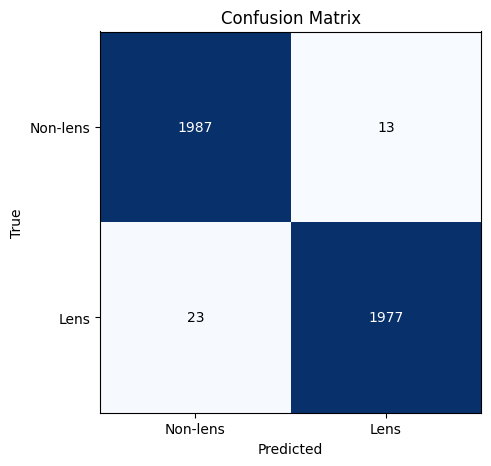

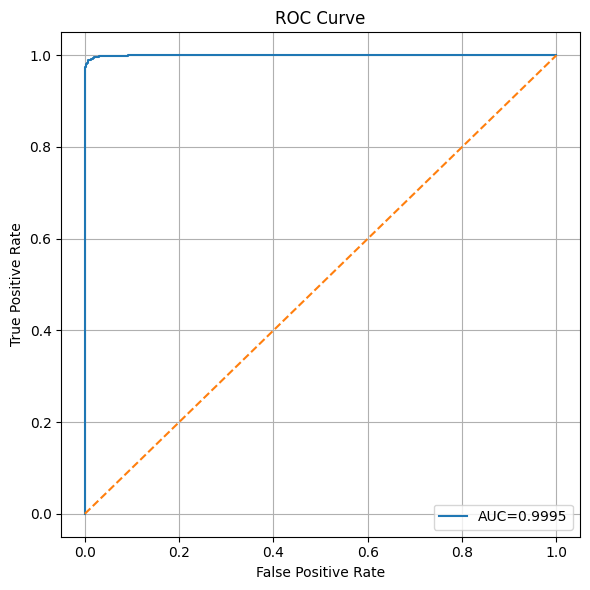

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    f1_score, precision_score, recall_score, accuracy_score
)

# ROC-based threshold (Youden J)
fpr, tpr, thr = roc_curve(all_labels, all_probs)
best_t = thr[np.argmax(tpr - fpr)]
preds = (all_probs >= best_t).astype(int)

acc = accuracy_score(all_labels, preds)
prec = precision_score(all_labels, preds, zero_division=0)
rec = recall_score(all_labels, preds)
f1 = f1_score(all_labels, preds)

try:
    auc = roc_auc_score(all_labels, all_probs)
except ValueError:
    auc = float("nan")

print(f"Best threshold t*: {best_t:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1:        {f1:.4f}")
print(f"AUC:       {auc:.4f}\n")

cm = confusion_matrix(all_labels, preds)
print("Confusion Matrix:\n", cm, "\n")

print("Classification Report:\n")
print(classification_report(all_labels, preds, digits=4))

# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1], ["Non-lens", "Lens"])
plt.yticks([0,1], ["Non-lens", "Lens"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center", color="white" if v > cm.max()/2 else "black")
plt.tight_layout()
plt.show()

# Plot ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Radius MAE:  0.0724
Radius RMSE: 0.1056
Radius R^2:  0.8541
Residual mean: -0.0033 | std: 0.1056


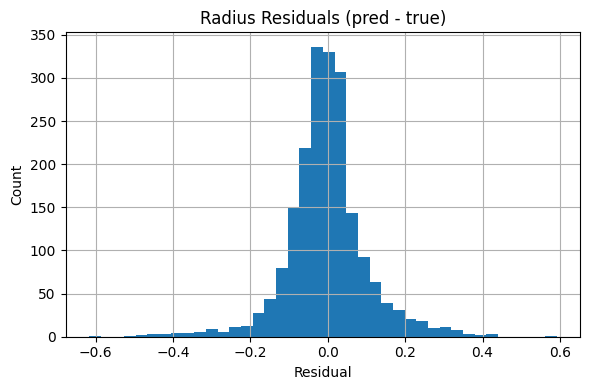

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

if len(all_r_true_phys) == 0:
    print("No y=1 samples found for radius evaluation.")
else:
    mae  = mean_absolute_error(all_r_true_phys, all_r_pred_phys)
    rmse = np.sqrt(mean_squared_error(all_r_true_phys, all_r_pred_phys))
    r2   = r2_score(all_r_true_phys, all_r_pred_phys)

    resid = all_r_pred_phys - all_r_true_phys

    print(f"Radius MAE:  {mae:.4f}")
    print(f"Radius RMSE: {rmse:.4f}")
    print(f"Radius R^2:  {r2:.4f}")
    print(f"Residual mean: {resid.mean():.4f} | std: {resid.std():.4f}")

    # Residual histogram
    plt.figure(figsize=(6,4))
    plt.hist(resid, bins=40)
    plt.title("Radius Residuals (pred - true)")
    plt.xlabel("Residual")
    plt.ylabel("Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

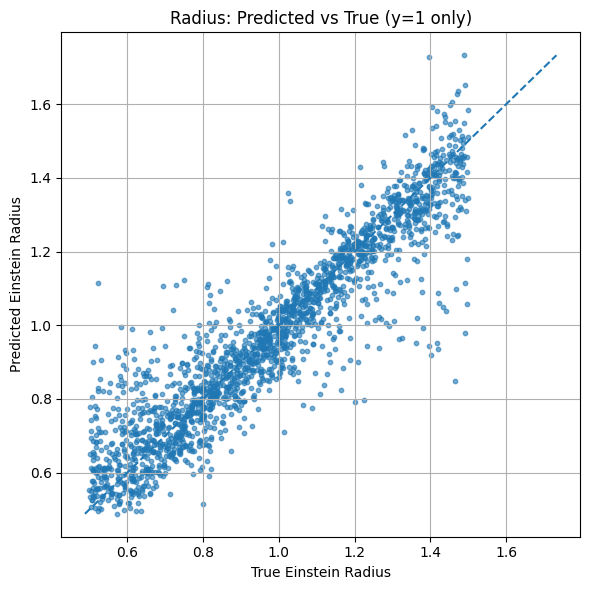

In [11]:
if len(all_r_true_phys) == 0:
    print("No y=1 samples found for radius evaluation.")
else:
    mn = min(all_r_true_phys.min(), all_r_pred_phys.min())
    mx = max(all_r_true_phys.max(), all_r_pred_phys.max())

    plt.figure(figsize=(6,6))
    plt.scatter(all_r_true_phys, all_r_pred_phys, s=10, alpha=0.6)
    plt.plot([mn, mx], [mn, mx], linestyle="--")  # y=x line
    plt.xlabel("True Einstein Radius")
    plt.ylabel("Predicted Einstein Radius")
    plt.title("Radius: Predicted vs True (y=1 only)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

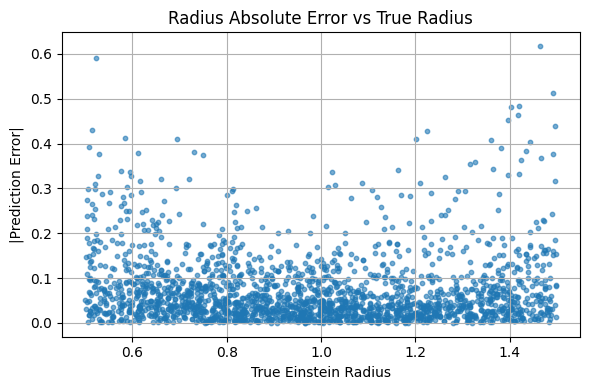

In [12]:
if len(all_r_true_phys) == 0:
    print("No y=1 samples found for radius evaluation.")
else:
    abs_err = np.abs(all_r_pred_phys - all_r_true_phys)

    plt.figure(figsize=(6,4))
    plt.scatter(all_r_true_phys, abs_err, s=10, alpha=0.6)
    plt.xlabel("True Einstein Radius")
    plt.ylabel("|Prediction Error|")
    plt.title("Radius Absolute Error vs True Radius")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:
import numpy as np

r_true = np.array(all_r_true_phys)
r_pred = np.array(all_r_pred_phys)

eps = 1e-8
rel_err = (r_true - r_pred) / (np.abs(r_true) + eps)

print("Relative error stats:")
print(f"  mean: {rel_err.mean():.4f}")
print(f"  std : {rel_err.std():.4f}")
print(f"  min : {rel_err.min():.4f}")
print(f"  max : {rel_err.max():.4f}")

# optional: percent form
rel_err_pct = 100.0 * rel_err

Relative error stats:
  mean: -0.0101
  std : 0.1309
  min : -1.1297
  max : 0.4213


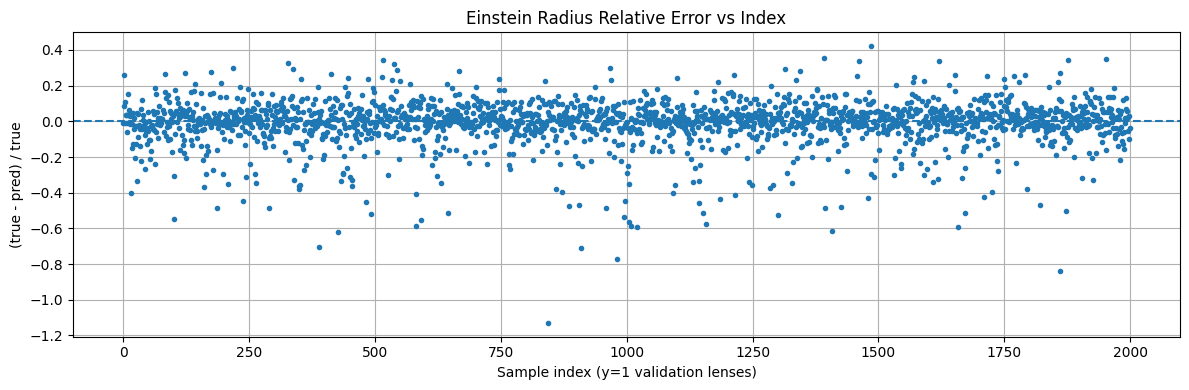

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(rel_err, marker='.', linestyle='None')  # scatter-like
plt.axhline(0.0, linestyle='--')
plt.xlabel("Sample index (y=1 validation lenses)")
plt.ylabel("(true - pred) / true")
plt.title("Einstein Radius Relative Error vs Index")
plt.grid(True)
plt.tight_layout()
plt.show()

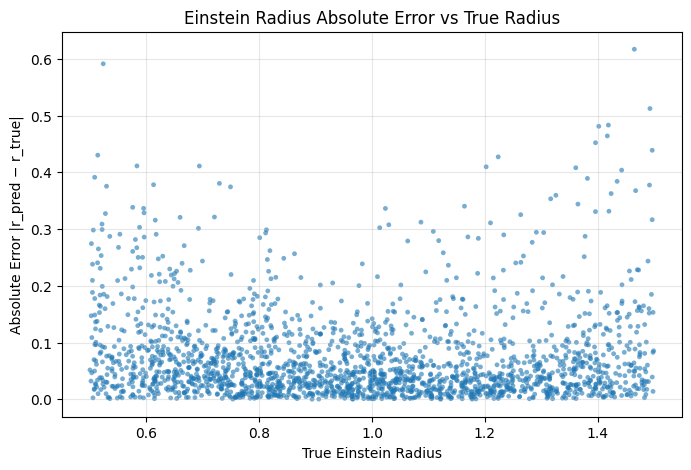

Absolute error stats:
  mean: 0.0724
  std : 0.0769
  min : 0.0000
  max : 0.6171


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to numpy
r_true = np.array(all_r_true)
r_pred = np.array(all_r_pred)

# If radii were normalized, convert back to physical units
r_true_phys = r_true * r_std + r_mean
r_pred_phys = r_pred * r_std + r_mean

abs_err = np.abs(r_pred_phys - r_true_phys)

plt.figure(figsize=(8, 5))
plt.scatter(
    r_true_phys,
    abs_err,
    s=12,
    alpha=0.6,
    edgecolor="none"
)

plt.xlabel("True Einstein Radius")
plt.ylabel("Absolute Error |r_pred − r_true|")
plt.title("Einstein Radius Absolute Error vs True Radius")
plt.grid(True, alpha=0.3)

plt.show()

# ---- stats ----
print("Absolute error stats:")
print(f"  mean: {abs_err.mean():.4f}")
print(f"  std : {abs_err.std():.4f}")
print(f"  min : {abs_err.min():.4f}")
print(f"  max : {abs_err.max():.4f}")

In [16]:
theta_e = np.load(os.path.join(path, "theta_Es.npy"))

print(f"theta_E min : {theta_e.min():.4f}")
print(f"theta_E max : {theta_e.max():.4f}")
print(f"theta_E mean: {theta_e.mean():.4f}")
print(f"theta_E std : {theta_e.std():.4f}")

theta_E min : 0.0000
theta_E max : 1.4999
theta_E mean: 0.4884
theta_E std : 0.5257
